<a href="https://colab.research.google.com/github/aashrat/stsci/blob/master/WFC3IR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
#need to pip install every time on colab, maybe this can be changed!
pip install astroquery

In [ ]:
#run this code to download the non-anomalous WFC3 data
from astroquery.mast import Observations
import glob
from astropy.io import fits
obs_table = Observations.query_criteria(target_name=["OMEGACEN","OMEGA-CEN"],filters=["F160W"], project="HST", instrument_name="WFC3/IR", intentType="science")
download_tab = Observations.download_products(obs_table["obsid"], mrp_only=False, productSubGroupDescription=["FLT"])

In [23]:
try:
    import wget
except:
    !python -m pip install wget
    import wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=31ff9b57ce6b1c5f809e6adca9c2b1d65627b87d079bc4edc96c2e854a2b950d
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [3]:
import numpy as np
import os
import tifffile
import torch

from matplotlib import pyplot as plt
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [4]:
#this line of code might need to be altered for running the WFC3 data, I'm not entirely sure on this
class AutoEncoderImageDataSet(Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, image, samples_per_epoch=1, subsize=128):
        'Initialization'
        self.image = image
        self.samples_per_epoch = samples_per_epoch
        self.subsize = subsize

  def __len__(self):
        'Denotes the total number of samples'
        return self.samples_per_epoch

  def __getitem__(self, index, ix=None, iy=None):
        '''Generates one sample of data
            Load data and get label
            
            On training:
                keep ix=iy=None to maintain random fields
            
            On testing:
                set ix=... and iy=... to test a specific field
                set ix=iy=None to test random fields
        '''

        return grab_random_subframes(
            self.image, subsize=self.subsize, ix=ix, iy=iy
        )

In [5]:
#flatten and unflatten classes are used to reduce dimensionality and bring back dimensions in the autoencoder class
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def forward(self, input, shape_before_flatten):
        return input.view(input.size(0), *shape_before_flatten)

Here are some PyTorch documentation links that were useful for figuring out what inputs made sense.

[PyTorch conv2d](https://pytorch.org/docs/master/generated/torch.nn.Conv2d.html) - under shape, there is some info on what kernel_size and padding should be used based on that equation

[Max Pool](https://pytorch.org/docs/master/generated/torch.nn.MaxPool2d.html) - we used 2x2 filter, but this can also be replaced by adding the argument "stride" into the convolution layers, which might be something to look into

In [12]:
#this is the main autoencoder class
class Autoencoder(nn.Module):
    #change filters to 3 to work with WFC3 data, not sure why something to look into
    def __init__(self, filters=[3, 32, 128, 256],
                 latent_dimensions=2,
                 sub_array_size=128):

        super().__init__()

        self.sub_array_size = sub_array_size
        self.filters = filters

        #3 convolutions, can experiment more with this to see which is best for WFC3 data
        self.conv1 = nn.Conv2d(filters[0], filters[1],kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(filters[1], filters[2],kernel_size=3,padding=1)
        self.conv3 = nn.Conv2d(filters[2], filters[3],kernel_size=3,padding=1)
        
        #activation function, there are other options (sigmoid, tanh, etc) that we could explore later
        self.relu = nn.ReLU()

        #can get rid of this by adding a stride = 2 argument in conv layers
        self.mp = nn.MaxPool2d(2,return_indices=True)

        #dividing by 2 after max pooling
        self.sub_array_size = self.sub_array_size // 2

        #flattening i.e. reducing dimmensions
        self.flatten = Flatten()

        #latent space
        size_before_latent = filters[-1] * self.sub_array_size**2
        self.latent = nn.Linear(size_before_latent, latent_dimensions)
        self.out_of_latent = nn.Linear(latent_dimensions, size_before_latent)

        #unflattening
        self.unflatten = UnFlatten()
        #max unpooling
        self.up = nn.MaxUnpool2d(2)
        #decoder layers
        self.trans1 = nn.ConvTranspose2d(filters[-1],filters[-2],kernel_size=3,padding=1)
        self.trans2 = nn.ConvTranspose2d(filters[-2],filters[-3],kernel_size=3,padding=1)
        self.trans3 = nn.ConvTranspose2d(filters[-3],filters[-4],kernel_size=3,padding=1)

    #calling all of these in forward statement
    def forward(self,x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.relu(x)
        x, ind = self.mp(x)
        shape_before_flatten = x.size()[1:]
        x = self.flatten(x)

        x = self.latent(x)
        x = self.out_of_latent(x)

        x = self.unflatten(x, shape_before_flatten)        
        x = self.up(x, ind)
        x = self.relu(x)
        x = self.trans1(x)
        x = self.relu(x)
        x = self.trans2(x)
        x = self.relu(x)
        x = self.trans3(x)
        x = self.relu(x)
        
        return x

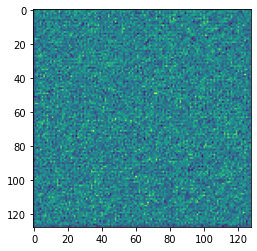

In [11]:
#testing with Hubble autoencoder
testing = Autoencoder()
randomimage = np.random.normal(0,1,size=(1,1,128,128))
testoutput = testing(torch.Tensor(randomimage))
plt.imshow(testoutput.detach().numpy()[0,0])

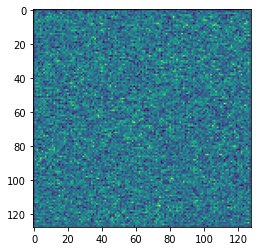

In [16]:
#testing with WFC3 autoencoder
testing = Autoencoder()
randomimage = np.random.normal(0,1,size=(3,3,128,128))
testoutput = testing(torch.Tensor(randomimage))
plt.imshow(testoutput.detach().numpy()[0,0])

In [17]:
def grab_random_subframes(image, ix=None, iy=None, subsize=128, channels_first=True):
    #take image_dir as argument instead of image
    ny, nx, *_ = image.shape

    if ix is None:
      ix = np.random.randint(subsize // 2, nx - subsize // 2)

    if iy is None:
      iy = np.random.randint(subsize // 2, ny - subsize // 2)

    xstart, xstop = ix - subsize // 2, ix + subsize // 2
    ystart, ystop = iy - subsize // 2, iy + subsize // 2

    features = image[ystart:ystop, xstart:xstop]

    if features.ndim == 2:
        # add channel (color) dimension to grey scal
        # necessary for using PreTrainedModel as `conv_base`
        features = np.ones((3, subsize, subsize))*features
        features = np.transpose(features, axes=(1,2,0))
    
    if channels_first:
        # Tensorflow: False
        # PyTorch: True
        features = np.transpose(features, axes=(2,0,1))

    return features  # No labels == autoencoder

In [20]:
#getting 1 hudf image from archives
def load_hudf(base_dir='./', normalize=False, store_byte=False):
    hudf_url = 'https://www.spacetelescope.org/static/archives/images/original/heic0611b.tif'
    hudf_location = os.path.join(base_dir, 'hudf_heic0611b.tif')
    if not os.path.exists(hudf_location):
        print('Beginning file HUDF download')
        wget.download(hudf_url, hudf_location)
        print('Completed file HUDF download')
    else:
        print(f'HUDF File Exists in {hudf_location}')

    #calculating memory
    hudf_image = tifffile.imread(hudf_location)
    print(f'The HUDF image is {hudf_image.size/3/1000**2:0.2f} MegaPixels')
    print(f'The HUDF image is {hudf_image.nbytes/1024**2:0.2f} MB on RAM')

    #normalizing image
    if normalize:
        hudf_image = hudf_image  / 255
    
    if store_byte:
        hudf_image = hudf_image.astype(int)

    print(f'The HUDF image min: {hudf_image.min()}')
    print(f'The HUDF image max: {hudf_image.max()}')

    return hudf_image

In [18]:
#function to get wfc3 data
def get_wfc3data():
  files = glob.glob("./mastDownload/HST/*/*flt.fits")
  hdr = fits.getheader(files[0], 1)
  nx = hdr["NAXIS1"]
  ny = hdr["NAXIS2"]
  nf = len(files)
  data_array = np.empty((nf, ny, nx), dtype=float)

  for i,f in enumerate(files):
    data = fits.getdata(f)
    data_array[i, :, :] = data
  
  wfc3_image = data
  wfc3_images = data_array
  print(f'The WFC3 image is {wfc3_image.size/3/1000**2:0.2f} MegaPixels')
  print(f'The WFC3 image is {wfc3_image.nbytes/1024**2:0.2f} MB on RAM')
  
  #returning one single image, change to load all
  return wfc3_image

In [13]:
#separating into training and validation
def configure_batch_generator(image, batch_size, shuffle,
                              samples_per_epoch=1,
                              subsize=128,
                              num_workers=2):

    params = {
        'batch_size': batch_size,
        'shuffle': shuffle,
        'num_workers': num_workers
    }

    # Use the top half of the image for training
    #   and the bottom have of the image for validation
    ny, nx = image.shape
    # Generators
    training_set = AutoEncoderImageDataSet(
        image[:ny//2],
        samples_per_epoch=samples_per_epoch,
        subsize=subsize
    )
    training_generator = DataLoader(training_set, **params)

    validation_set = AutoEncoderImageDataSet(
        image[ny//2:],
        samples_per_epoch=samples_per_epoch,
        subsize=subsize
    )
    validation_generator = DataLoader(validation_set, **params)

    return training_generator, training_set,\
            validation_generator, validation_set

In [21]:
#define r2 score
def r2score_manual(validation_set, n_images=100):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    data_variance = 0
    res_variance = 0
    for _ in range(n_images):
        image_ = validation_set.__getitem__(0, ix=None, iy=None)

        torch_image_ = torch.unsqueeze(torch.from_numpy(image_), 0).to(device).float()
        with torch.no_grad():
            pred_image_ = model.forward(torch_image_).to('cpu').numpy()
            pred_image_ = pred_image_[0].astype(float)

        data_var_ = np.nansum((image_ - np.mean(image_))**2)
        res_var_ = np.nansum((image_ - pred_image_)**2)
        data_variance = data_variance + data_var_
        res_variance = res_variance + res_var_

        del image_, pred_image_

    return 1 - res_variance / data_variance

In [28]:
#calling functions
base_dir = '/content/'
hudf_image = load_hudf(base_dir=base_dir, normalize=True, store_byte=False)
wfc3_image = get_wfc3data()

In [16]:
#defining batch size, samples per epoch, number of epochs, etc
args = {
    'batch_size':64,
    'subsize':128,
    'shuffle':True,
    'samples_per_epoch':20000,
    'num_workers':2,
}

num_epochs = 20
train_loader, train_set, val_loader, val_set = configure_batch_generator(
    wfc3_image, **args
)

In [17]:
#defining autoencoder and optimizer
model = Autoencoder()#.cpu()
distance = nn.MSELoss()

#using Adam here
optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-5)

model.float()
for layer in model.modules():
    if isinstance(layer, nn.BatchNorm2d):
        layer.float()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device);

/usr/local/lib/python3.6/dist-packages/torch/cuda/__init__.py:125: UserWarning: 
Tesla T4 with CUDA capability sm_75 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the Tesla T4 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


In [18]:
#actually running autoencoder
for epoch in tqdm(range(num_epochs), total=num_epochs):
    for data in train_loader:
        img = data
        img = img.float().to(device)  # torch.from_numpy(

        # ===================forward=====================
        output = model(img)
        loss = distance(output, img)

        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # ===================log========================

    r2_score_ = r2score_manual(val_set, n_images=10000)
    with torch.no_grad():
        print(f'\tepoch [{epoch+1:02}/{num_epochs}], loss:{loss.cpu().data.numpy():.4e}, R2:{r2_score_:.4f}')

  0%|          | 0/20 [00:00<?, ?it/s]


NameError: ignored

In [ ]:
#get image from validation set
image_ = val_set.__getitem__(None, ix=None, iy=None)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
with torch.no_grad():
    torch_image_ = torch.unsqueeze(torch.from_numpy(image_), 0).to(device).float()
    pred_image_ = model(torch_image_).to('cpu').numpy()

image_ = np.transpose(image_, axes=(1,2,0))
pred_image_ = np.transpose(pred_image_[0].astype(float), axes=(1,2,0))

In [ ]:
#plot validation image, prediction, and difference
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24,8));
ax[0].imshow(image_);
ax[1].imshow(pred_image_);
ax[2].imshow(image_ - pred_image_);
ax[0].set_title('Hubble Ultra Deep Field', fontsize=20);
ax[1].set_title('AutoEncoder Reconstruction', fontsize=20);
ax[2].set_title('Difference Image', fontsize=20);
ax[0].axis('off');
ax[1].axis('off');
ax[2].axis('off');